In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
import time
import warnings
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
import sqlite3
from sqlalchemy import create_engine 
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier

import scipy.stats as sc

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [3]:
df = pd.read_csv('train.csv')

# Preprocessing the data

In [4]:
STOP_WORDS = stopwords.words("english")
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000","m").replace(",000","k").replace("what's","what is").replace("won't","will not").replace("isn't","is not")\
                            .replace("′", "'").replace("’", "'").replace("n't"," not").replace("cannot","can not").replace("can't","can not")\
                            .replace("'ve"," have").replace("i'm","i am").replace("'re"," are")\
                            .replace("he's","he is").replace("she's","she is").replace("'s"," own")\
                            .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    
    x = re.sub(r"([0-9]+)000000",r"\1m",x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    porter =  PorterStemmer()
    pattern = re.compile("\W")
    
    if type(x) == type(''):
        x = re.sub(pattern,' ',x)
        
    if type(x) == type(''):
        x = porter.stem(x)
        bs4 = BeautifulSoup(x)
        x = bs4.get_text()
    
    return x

In [5]:
df['question1'] = df['question1'].fillna('').apply(preprocess)
df['question2'] = df['question2'].fillna('').apply(preprocess)
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))
from sklearn.feature_extraction.text import TfidfVectorizer
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0


# Random splitting the data

In [6]:
y_true = df['is_duplicate']
data = df.drop(['is_duplicate'],axis = 1)
from sklearn.model_selection import train_test_split
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.2)

# Distribution of y's

In [7]:
from collections import Counter, defaultdict
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308033837097133 Class 1:  0.36919661629028666
---------- Distribution of output variable in test data ----------
Class 0:  0.6307972000296816 Class 1:  0.36920279997031835


# Confusion Matrix

In [8]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8859002063257958


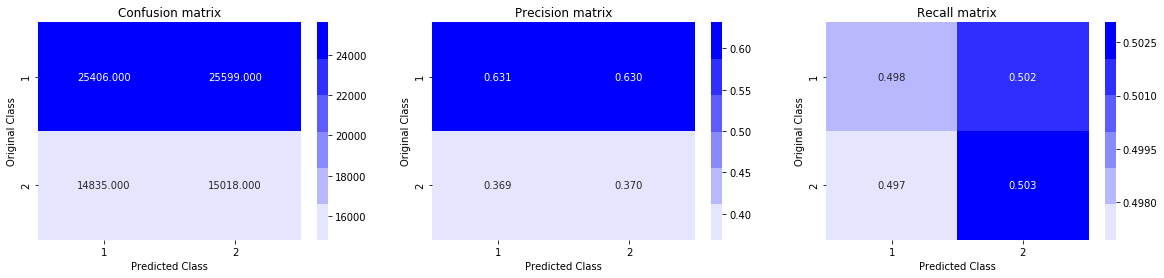

In [9]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

# TF-IDF Vectorization

In [10]:
tfidf = TfidfVectorizer(min_df = 3,ngram_range = (1,4),lowercase = False)
train_questions = X_train['question1'] + X_train['question2']
tfidf_train_feature = tfidf.fit_transform(train_questions)
train_X = normalize(tfidf_train_feature,axis = 0)

te_questions = X_test['question1'] + X_test['question2']
tfidf_test_feature = tfidf.transform(te_questions)
test_X = normalize(tfidf_test_feature,axis = 0)

In [11]:
print(len(train_questions))
print(len(y_train))

323432
323432


<h2>  Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4516793447927014
For values of alpha =  0.0001 The log loss is: 0.4795578637015445
For values of alpha =  0.001 The log loss is: 0.4872468181994336
For values of alpha =  0.01 The log loss is: 0.4881462788150324
For values of alpha =  0.1 The log loss is: 0.5251212177947531
For values of alpha =  1 The log loss is: 0.5464826122128917
For values of alpha =  10 The log loss is: 0.5501706801768304


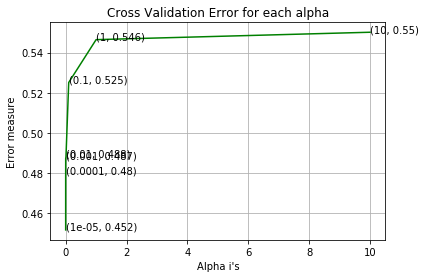

For values of best alpha =  1e-05 The train log loss is: 0.2726911114819622
For values of best alpha =  1e-05 The test log loss is: 0.4516793447927014
Total number of data points : 80858


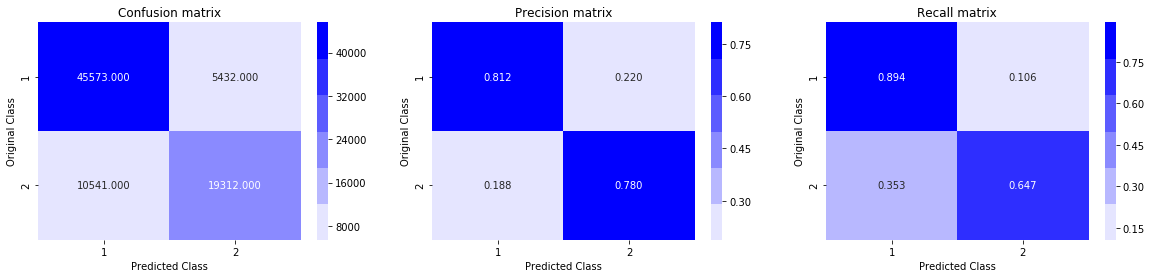

In [12]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_X, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_X, y_train)
    predict_y = sig_clf.predict_proba(test_X)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_X, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_X, y_train)

predict_y = sig_clf.predict_proba(train_X)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_X)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2>  Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.5396886476308184
For values of alpha =  0.0001 The log loss is: 0.6531949035942174
For values of alpha =  0.001 The log loss is: 0.6585300338918999
For values of alpha =  0.01 The log loss is: 0.6585300338918999
For values of alpha =  0.1 The log loss is: 0.6585300338918515
For values of alpha =  1 The log loss is: 0.6585300338918865
For values of alpha =  10 The log loss is: 0.6585300338918579


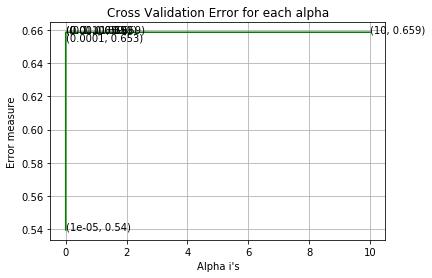

For values of best alpha =  1e-05 The train log loss is: 0.5213049392100703
For values of best alpha =  1e-05 The test log loss is: 0.5396886476308184
Total number of data points : 80858


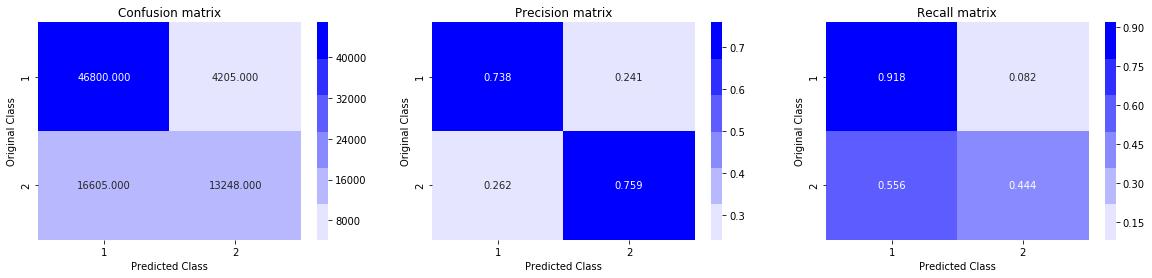

In [13]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.



log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(train_X, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_X, y_train)
    predict_y = sig_clf.predict_proba(test_X)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(train_X, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_X, y_train)

predict_y = sig_clf.predict_proba(train_X)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_X)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# XGBoost

In [16]:
import scipy.stats as sc
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
params = {"learning_rate":sc.uniform(0.01,0.1),
             "n_estimators":sc.randint(10,250),
             "max_depth":sc.randint(4,10),
             "min_child_weight":sc.randint(3,10),
        }
xgb_classifier = xgb.XGBClassifier(objective = 'binary:logistic')
grid = RandomizedSearchCV(xgb_classifier, params, cv = 3, scoring = "log_loss", verbose = 1, random_state = 0)
grid.fit(train_X,y_train)
print(grid.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 496.4min finished


{'learning_rate': 0.09009107519796443, 'max_depth': 9, 'min_child_weight': 6, 'n_estimators': 157}


The train log loss is: 0.46084083830201533
/n The test log loss is: 0.5837452054630318
/n Total number of data points : 80858


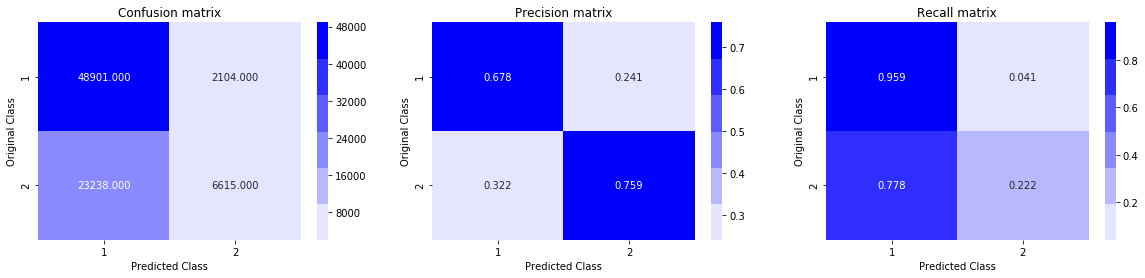

In [17]:
predict_y = grid.predict_proba(train_X)
print("The train log loss is:",log_loss(y_train, predict_y, eps=1e-15))
predict_y = grid.predict_proba(test_X)
print("/n The test log loss is:",log_loss(y_test, predict_y, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("/n Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [3]:
from prettytable import PrettyTable
x = PrettyTable()
x.add_column("Sno.",[1,2,3,4])
x.add_column("Model",['Random','Logistic_Regression','Linear SVM','Xgboost'])
x.add_column("Test Log Loss",['0.88','0.451','0.539','0.583'])
print(x)

+------+---------------------+---------------+
| Sno. |        Model        | Test Log Loss |
+------+---------------------+---------------+
|  1   |        Random       |      0.88     |
|  2   | Logistic_Regression |     0.451     |
|  3   |      Linear SVM     |     0.539     |
|  4   |       Xgboost       |     0.583     |
+------+---------------------+---------------+


# Conclusion

* In this notebook ,we have applied Tfidf Vectorization and fitted on the training data(e.g all train questions including q1 and q2) so that vectorizer could learn and could then transform the test data based on training data.
* We further applied the machine learning model e.g Logistic Regression , Linear SVM and Xgboost.
* We are evaluating log-loss as performance metric so that we can find which one is giving good results based on log-loss.
* At last we have compared the results of above models.